In [1]:
using Pkg
pkg"activate ."

In [2]:
using PerlaTonettiWaugh, LinearAlgebra, Plots, BenchmarkTools, Interpolations, QuadGK, DifferentialEquations, BlackBoxOptim, Optim, DataFrames

┌ Info: Recompiling stale cache file C:\Users\Chiyoung Ahn\.julia\compiled\v1.0\PerlaTonettiWaugh\Zi3ee.ji for PerlaTonettiWaugh [d2cacc76-b06b-11e8-362b-f18d03a16405]
└ @ Base loading.jl:1184
┌ Warning: Package PerlaTonettiWaugh does not have BlackBoxOptim in its dependencies:
│ - If you have PerlaTonettiWaugh checked out for development and have
│   added BlackBoxOptim as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with PerlaTonettiWaugh
└ Loading BlackBoxOptim into PerlaTonettiWaugh from project dependency, future warnings for PerlaTonettiWaugh are suppressed.


# Steady states

## Solving steady state solutions

Set up parameters and find the corresponding stationary solution:

In [3]:
z_min = 0.0 
z_max = 5.0

z_grid = unique([range(0., 0.1, length = 50)' range(0.1, 1., length = 150)' range(1., 2., length = 100)' range(2., 5., length = 50)'])
M = length(z_grid)

# Define common objects. 
d_0 = 8
d_T = 2.3701
params = (ρ = 0.02, σ = 3.9896, N = 10, θ = 4.7060, γ = 1.00, κ = 0.0103, ζ = 1, η = 0, Theta = 1, χ = 0.4631, υ = 0.0775, μ = 0, δ = 0.053) # Baselines per Jesse.
δ = params.δ
# solve for stationary solution at t = 0
params_0 = merge(params, (d = d_0,)) # parameters to be used at t = 0
params_T = merge(params, (d = d_T,)) # parameters to be used at t = T


stationary_sol_0 = stationary_numerical(params_0, z_grid) # solution at t = 0
stationary_sol = stationary_numerical(params_T, z_grid) # solution at t = T

Ω_0 = stationary_sol_0.Ω
Ω_T = stationary_sol.Ω
settings = (z = z_grid, tstops = nothing, Δ_E = 1e-06)

(z = [0.0, 0.00204082, 0.00408163, 0.00612245, 0.00816327, 0.0102041, 0.0122449, 0.0142857, 0.0163265, 0.0183673  …  4.44898, 4.5102, 4.57143, 4.63265, 4.69388, 4.7551, 4.81633, 4.87755, 4.93878, 5.0], tstops = nothing, Δ_E = 1.0e-6)

## Welfare in steady states

In [4]:
# auxil. function that extracts and displays welfare information from steady state solutions
function display_stationary_sol(stationary_sol)
    @unpack g, z_hat, Ω, π_bar_agg, y, c, λ_ii, U_bar, L_tilde, z_bar, w, x, π_min, r, a, b, S = stationary_sol
    summary_df1 = DataFrame(g = g, z_hat = z_hat, Ω = Ω, π_bar_agg = π_bar_agg, 
                            y = y, c = c, λ_ii = λ_ii)
    summary_df2 = DataFrame(U_bar_0 = U_bar(0.0),
                            L_tilde = L_tilde, z_bar = z_bar, w = w, x = x, π_min = π_min)
    summary_df3 = DataFrame(r = r, a = a, b = b, S = S)
    println(summary_df1)
    println(summary_df2)    
    println(summary_df3)
end;

### Steady state at `T`

In [5]:
display_stationary_sol(stationary_sol)

1×7 DataFrame
│ Row │ g         │ z_hat   │ Ω       │ π_bar_agg │ y       │ c       │ λ_ii     │
│     │ Float64   │ Float64 │ Float64 │ Float64   │ Float64 │ Float64 │ Float64  │
├─────┼───────────┼─────────┼─────────┼───────────┼─────────┼─────────┼──────────┤
│ 1   │ 0.0244899 │ 1.3194  │ 1.13516 │ 0.234427  │ 1.29361 │ 1.29361 │ 0.702314 │
1×6 DataFrame
│ Row │ U_bar_0 │ L_tilde  │ z_bar   │ w       │ x       │ π_min     │
│     │ Float64 │ Float64  │ Float64 │ Float64 │ Float64 │ Float64   │
├─────┼─────────┼──────────┼─────────┼─────────┼─────────┼───────────┤
│ 1   │ 74.0967 │ 0.213796 │ 1.64539 │ 0.41242 │ 1.0     │ 0.0593421 │
1×4 DataFrame
│ Row │ r         │ a       │ b        │ S         │
│     │ Float64   │ Float64 │ Float64  │ Float64   │
├─────┼───────────┼─────────┼──────────┼───────────┤
│ 1   │ 0.0974899 │ 8.37704 │ 0.128284 │ 0.0487409 │


### Steady state at `0`

In [6]:
display_stationary_sol(stationary_sol_0)

1×7 DataFrame
│ Row │ g          │ z_hat   │ Ω       │ π_bar_agg │ y       │ c       │ λ_ii     │
│     │ Float64    │ Float64 │ Float64 │ Float64   │ Float64 │ Float64 │ Float64  │
├─────┼────────────┼─────────┼─────────┼───────────┼─────────┼─────────┼──────────┤
│ 1   │ 0.00283003 │ 5.15409 │ 2.6602  │ 0.27984   │ 1.62742 │ 1.62742 │ 0.998925 │
1×6 DataFrame
│ Row │ U_bar_0 │ L_tilde  │ z_bar   │ w       │ x       │ π_min     │
│     │ Float64 │ Float64  │ Float64 │ Float64 │ Float64 │ Float64   │
├─────┼─────────┼──────────┼─────────┼─────────┼─────────┼───────────┤
│ 1   │ 31.4248 │ 0.163062 │ 1.94449 │ 0.48739 │ 1.0     │ 0.0383411 │
1×4 DataFrame
│ Row │ r       │ a       │ b        │ S          │
│     │ Float64 │ Float64 │ Float64  │ Float64    │
├─────┼─────────┼─────────┼──────────┼────────────┤
│ 1   │ 0.07583 │ 18.3084 │ -140.527 │ -0.0531904 │


# Transition dynamics

Define the objective function:

In [7]:
function solve_with_candidate(candidate)
    T = candidate[end]
    candidate = [sort(candidate[1:(end-1)]); 0.0] # fix the point at T to be zero

    # construct Ω and E
    E_hat_vec_range = candidate[end] - candidate[1]
    E_hat_vec_scaled = (candidate .- candidate[1]) ./ E_hat_vec_range .- 1.0 
    ts = range(0.0, stop=T, length=length(candidate))
    E_hat_interpolation = CubicSplineInterpolation(ts, E_hat_vec_scaled) # might worth trying cubic spline
    E_hat(t) = E_hat_interpolation(t)

    M = log(Ω_T/Ω_0) / quadgk(E_hat, 0, T)[1]
    Ω_derivative(Ω,p,t) = M*E_hat(t)*Ω
    Ω_solution = DifferentialEquations.solve(ODEProblem(Ω_derivative,Ω_0,(0.0, T)), reltol = 1e-15)
    Ω(t) = t <= T ? Ω_solution(t) : Ω_solution(T)
    E(t) = M*E_hat(t) + δ
    
    # solve the dynamics and get the resulting entry_residual vector; if solution is not valid, return Inf
    return solve_dynamics(params_T, stationary_sol, settings, T, Ω, E; detailed_solution = true)
end

function residuals_given_solution(solved, ENTRY_RESIDUALS_NODES_COUNT)
  # interpolate on returned entry_residual
  entry_residual_interpolated = LinearInterpolation(solved.t, solved.entry_residual)

  # evaluate entry_residual on entry_residual_nodes, return the norm
  entry_residuals_nodes = range(0, stop = solved.t[end], length = ENTRY_RESIDUALS_NODES_COUNT + 2)
  
  # returns the vector of residuals
  return entry_residual_interpolated.(entry_residuals_nodes[2:(end-1)])
end

function evaluate_candidate_with_ssr(candidate)
#   candidate = [candidate...] # if candidate is a tuple, convert it to an array
  # solve the dynamics; if solution is not valid, return Inf
  solved = try solve_with_candidate(candidate).results catch; return Inf end
  # get the resulting entry_residual vector
  residuals = residuals_given_solution(solved, ENTRY_RESIDUALS_NODES_COUNT)
  return (sqrt(sum(residuals .* WEIGHTS .* residuals)))
end

evaluate_candidate_with_ssr (generic function with 1 method)

Setup for optimizer:

In [8]:
SOLUTION = [-0.29289587818815976; -0.1333218306767743; -0.08942934611931058;  -0.018386019083147458; -0.08930489493014641;  -0.941358463553554;  -0.41788897050932516;  -0.5667354234090646;   -0.01700255640563696;  -0.035690205818277365; -0.7468699888323547;   -0.21670305161145972;  -0.022706851500478447; -0.01700298441332641;  34.99997676121191]    
ENTRY_RESIDUALS_NODES_COUNT = 15
E_NODE_COUNT = 15
RANGES_NODES = map(i->(SOLUTION[i] - 5e-2, min(-1e-3, SOLUTION[i] + 5e-2)), 1:(E_NODE_COUNT-1))
RANGES = [RANGES_NODES; (34.999, 35.001)]
WEIGHTS = [fill(15, 3); fill(1, ENTRY_RESIDUALS_NODES_COUNT-3)];
settings_optim = (E_node_count = E_NODE_COUNT, entry_residuals_nodes_count = ENTRY_RESIDUALS_NODES_COUNT, 
                weights = WEIGHTS, ranges = RANGES, iterations = 2)
settings = merge(settings, settings_optim)

(z = [0.0, 0.00204082, 0.00408163, 0.00612245, 0.00816327, 0.0102041, 0.0122449, 0.0142857, 0.0163265, 0.0183673  …  4.44898, 4.5102, 4.57143, 4.63265, 4.69388, 4.7551, 4.81633, 4.87755, 4.93878, 5.0], tstops = nothing, Δ_E = 1.0e-6, E_node_count = 15, entry_residuals_nodes_count = 15, weights = [15, 15, 15, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], ranges = Tuple{Float64,Float64}[(-0.342896, -0.242896), (-0.183322, -0.0833218), (-0.139429, -0.0394293), (-0.068386, -0.001), (-0.139305, -0.0393049), (-0.991358, -0.891358), (-0.467889, -0.367889), (-0.616735, -0.516735), (-0.0670026, -0.001), (-0.0856902, -0.001), (-0.79687, -0.69687), (-0.266703, -0.166703), (-0.0727069, -0.001), (-0.067003, -0.001), (34.999, 35.001)], iterations = 2)

Find the corresponding solution:

In [9]:
solved = solve_full_model_global(SOLUTION, params_T, stationary_sol, Ω_0, settings)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
16.89 secs, 2 evals, 1 steps, fitness=0.517670343
46.29 secs, 4 evals, 2 steps, fitness=0.486853436

Optimization stopped after 3 steps and 66.9430000782013 seconds
Termination reason: Max number of steps (2) reached
Steps per second = 0.04481424490231194
Function evals per second = 0.08962848980462387
Improvements/step = 0.5
Total function evaluations = 6


Best candidate found: [-0.257997, -0.0907122, -0.0852893, -0.0482907, -0.128106, -0.900666, -0.399126, -0.529603, -0.0394144, -0.0589436, -0.76493, -0.244476, -0.0491038, -0.0300568, 35.0005]

Fitness: 0.486853436



(results = 48×15 DataFrame. Omitted printing of 9 columns
│ Row │ t        │ g         │ z_hat   │ Ω       │ E          │ v_0     │
│     │ Float64  │ Float64   │ Float64 │ Float64 │ Float64    │ Float64 │
├─────┼──────────┼───────────┼─────────┼─────────┼────────────┼─────────┤
│ 1   │ 0.0      │ 0.0219542 │ 1.5239  │ 2.6602  │ -0.043755  │ 1.3186  │
│ 2   │ 0.1482   │ 0.0220733 │ 1.52039 │ 2.62245 │ -0.0431142 │ 1.31531 │
│ 3   │ 0.697112 │ 0.0225744 │ 1.50786 │ 2.48934 │ -0.0406626 │ 1.30269 │
│ 4   │ 1.24602  │ 0.023097  │ 1.49598 │ 2.36633 │ -0.0379057 │ 1.28937 │
│ 5   │ 1.79494  │ 0.0235295 │ 1.48488 │ 2.25312 │ -0.034603  │ 1.27533 │
│ 6   │ 2.34385  │ 0.0237616 │ 1.47477 │ 2.14967 │ -0.030514  │ 1.26084 │
│ 7   │ 2.89276  │ 0.0236393 │ 1.46532 │ 2.05611 │ -0.0254449 │ 1.24682 │
│ 8   │ 3.44167  │ 0.0232126 │ 1.45692 │ 1.97255 │ -0.0196577 │ 1.23396 │
│ 9   │ 3.99058  │ 0.0226156 │ 1.44909 │ 1.89855 │ -0.0136722 │ 1.22314 │
│ 10  │ 4.5395   │ 0.0219912 │ 1.44156 │ 1.83322 │ -0.

In [10]:
v_t0 = solved.sol.u[1][1:M]
v0 = solved.results[:v_0]
# save v0 and v_hat_t0
v_hat_t0 = map(z -> exp((params.σ-1)*z), z_grid) .* v_t0;

solved = solved.results;

## Plots for Ω and `entry_residuals`

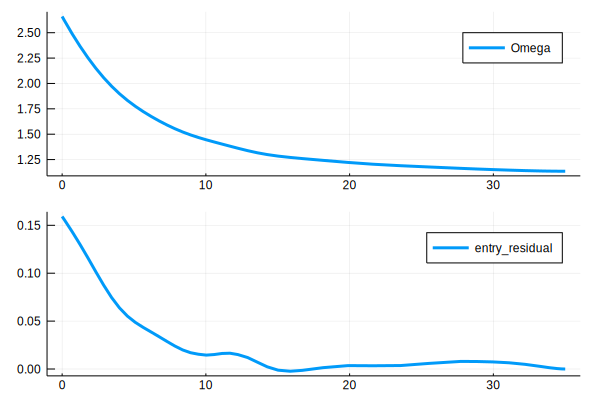

In [11]:
plot_Ω = plot(solved.t, solved.Ω, label = "Omega", lw = 3)
plot_residual = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot_Ω, plot_residual, layout = (2,1))

## Primary Plots

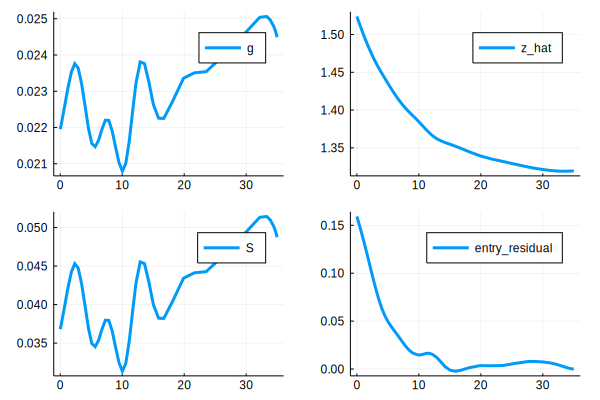

In [12]:
plot1 = plot(solved.t, solved.g, label = "g", lw = 3)
plot2 = plot(solved.t, solved.z_hat, label = "z_hat", lw = 3)
plot3 = plot(solved.t, solved.S, label = "S", lw = 3)
plot4 = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot1, plot2, plot3, plot4, layout=(2,2))

## Static Equations

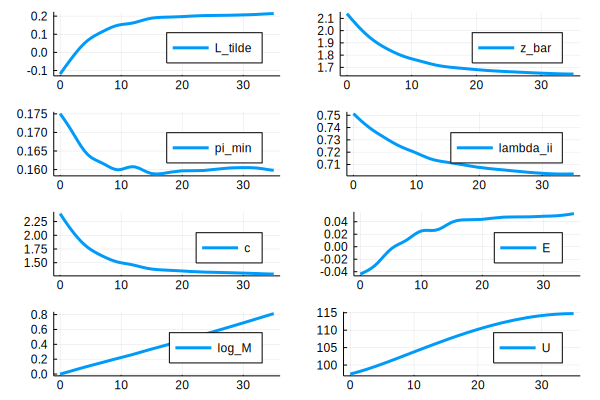

In [13]:
plot1 = plot(solved.t, solved.L_tilde, label = "L_tilde", lw = 3)
plot2 = plot(solved.t, solved.z_bar, label = "z_bar", lw = 3)
plot3 = plot(solved.t, solved.π_min, label = "pi_min", lw = 3)
plot4 = plot(solved.t, solved.λ_ii, label = "lambda_ii", lw = 3)
plot5 = plot(solved.t, solved.c, label = "c", lw = 3)
plot6 = plot(solved.t, solved.E, label = "E", lw = 3)
plot7 = plot(solved.t, solved.log_M, label = "log_M", lw = 3)
plot8 = plot(solved.t, solved.U, label = "U", lw = 3)
plot9 = plot(z_grid, v_hat_t0, label = "v_hat at t = 0", lw = 3)
plot(plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, layout=(4,2))

# Welfare analysis

### `log_M(t)`

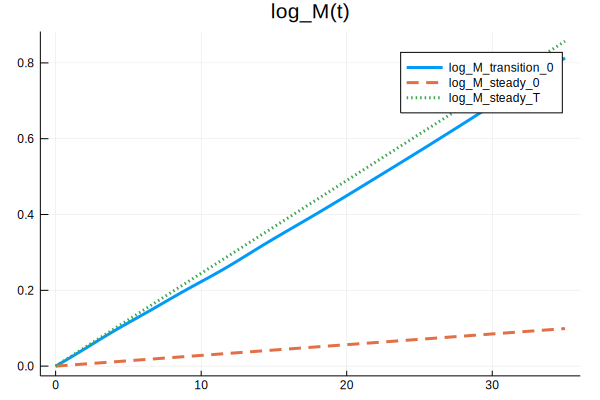

In [14]:
# define log_M with steady state g
log_M_steady_0(t) = stationary_sol_0.g * t
log_M_steady_T(t) = stationary_sol.g * t

# generate the plot!
plot(solved.t, 
    [solved.log_M, log_M_steady_0, log_M_steady_T], 
    label = ["log_M_transition_0", "log_M_steady_0", "log_M_steady_T"] ,
    title = "log_M(t)", linestyle = :auto, lw = 3)

### `Ω(t)`

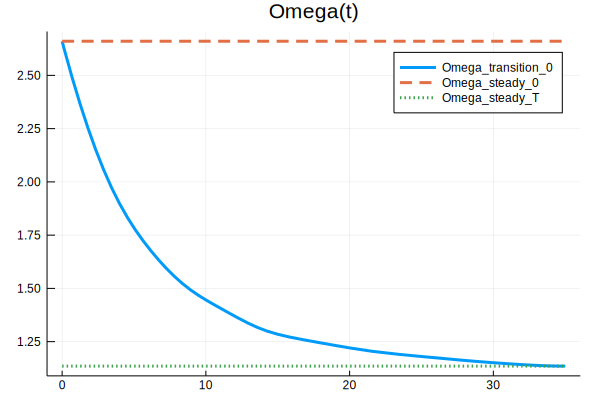

In [15]:
# define Ω function (constant)
Ω_steady_0(t) = stationary_sol_0.Ω
Ω_steady_T(t) = stationary_sol.Ω

# generate the plot!
plot(solved.t, 
    [solved.Ω, Ω_steady_0, Ω_steady_T], 
    label = ["Omega_transition_0", "Omega_steady_0", "Omega_steady_T"] ,
    title = "Omega(t)", linestyle = :auto, lw = 3)

### `c(t)`

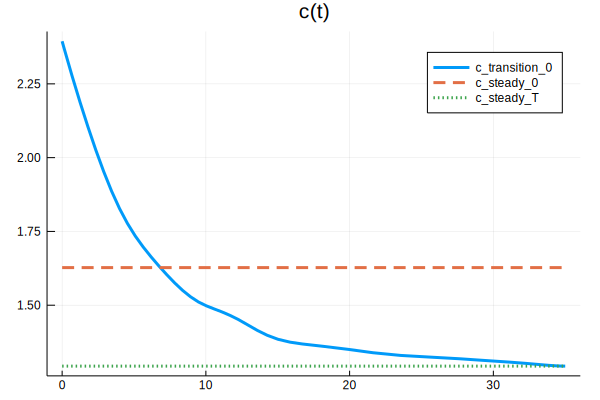

In [16]:
# define c function (constant)
c_steady_0(t) = stationary_sol_0.c
c_steady_T(t) = stationary_sol.c

# generate the plot!
plot(solved.t, 
    [solved.c, c_steady_0, c_steady_T], 
    label = ["c_transition_0", "c_steady_0", "c_steady_T"] ,
    title = "c(t)", linestyle = :auto, lw = 3)

### `U(t)`

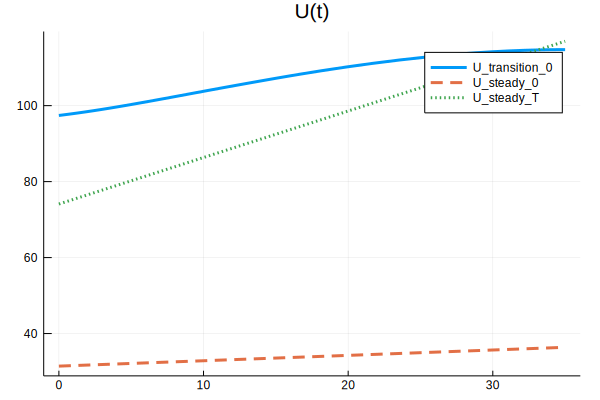

In [17]:
# # define c function (constant)
# ρ = params.ρ
# T = solved.t[end]
# U_steady_0(t) = (ρ*(log(stationary_sol_0.c + stationary_sol_0.g * t)) + stationary_sol_0.g)/(ρ^2)
# U_steady_T(t) = (ρ*(log(stationary_sol.c) + stationary_sol.g * t) + stationary_sol.g)/(ρ^2)
# U_steady_T(t) = (ρ*(log(stationary_sol.c) * stationary_sol.g*t) + stationary_sol.g) / (ρ^2)
# generate the plot!
plot(solved.t, 
    [solved.U, stationary_sol_0.U_bar, stationary_sol.U_bar], 
    label = ["U_transition_0", "U_steady_0", "U_steady_T"] ,
    title = "U(t)", linestyle = :auto, lw = 3)

## Consumption equivalent for search threshold (`M(0)`)
See computational appendix for details.

### `M(0)` by two steady states (autarky and steady state at `T`)

In [18]:
T = solved.t[end]
M_0 = exp(params.ρ*(stationary_sol.U_bar(T) - stationary_sol_0.U_bar(T)))

5.010538640545439

### `M(0)` by autarky and transition from `t=0`

In [19]:
T = solved.t[end]
M_0 = exp(params.ρ*(solved.U[1] - stationary_sol_0.U_bar(T)))

3.3898376442144205